In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant


In [9]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/.env.example


True

In [10]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("results/llama3.2-vision_11b-functionary-small/emails.db")
# conn = sqlite3.connect("src/data/db/llama3.2-vision_11b-functionary-small/emails.db")

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
0,93185A89130149C0A842968E4AFDCAA2,RobinLevine@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 43925,Hi Tanya ! Please find attached payment screen...,transaction_1.jpeg,SUCCESS,"I apologize for the confusion, but I cannot pr...",2025-01-22T09:48:50.367784,2025-01-22T09:48:55.630499,5.2627,2,643,539,104,0.0
1,614972488B7B411BAEA4814CF066CDAA,StevenNixon@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 51782,Hi Tanya ! Please find attached payment screen...,transaction_2.jpeg,SUCCESS,<|python_tag|> 1. I have retrieved the invoice...,2025-01-22T09:48:55.640352,2025-01-22T09:48:56.424000,0.7836,6,1911,1617,294,0.0
2,C484ABEB38F44D29960B1CEF58510627,MadisonFord@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 42968,Hi Tanya ! Please find attached payment screen...,transaction_3.jpeg,SUCCESS,"After processing the OCR, here is the extracte...",2025-01-22T09:48:56.433148,2025-01-22T09:48:59.500173,3.0670,22,7222,5924,1298,0.0
3,706B3403E8024178948B3BFBF9E64A25,KathrynJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 92948,Hi Tanya ! Please find attached payment screen...,transaction_4.jpeg,SUCCESS,We have successfully retrieved data from the O...,2025-01-22T09:48:59.509513,2025-01-22T09:49:00.551315,1.0418,33,10851,8883,1968,0.0
4,86838440CA6C472AACFA3FCE1382609C,ChristineOwens@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 20304,Hi Tanya ! Please find attached payment screen...,transaction_5.jpeg,SUCCESS,I have just completed processing the OCR data ...,2025-01-22T09:49:00.560827,2025-01-22T09:49:01.466274,0.9054,46,15112,12372,2740,0.0


In [11]:
import json

json_file = "results/llama3.2-vision_11b-functionary-small/full_logs.json"

if "full_logs" in df.columns:
    last_completed = df[df["full_logs"] != ""].iloc[-1]
    full_logs = json.loads(last_completed["full_logs"])
    json.dump(full_logs, open(json_file, "w"), indent=4)
    conn.execute("ALTER TABLE emails DROP COLUMN full_logs")
    conn.execute("VACUUM")
    conn.commit()
    print("full_logs saved to", json_file)
else:
    full_logs = json.load(open(json_file))
    print("full_logs loaded from", json_file)

# Close the connection
conn.close()

full_logs loaded from results/llama3.2-vision_11b-functionary-small/full_logs.json


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   email_id             2000 non-null   object
 1   sender_email         2000 non-null   object
 2   recipient_email      2000 non-null   object
 3   subject              2000 non-null   object
 4   email_body           2000 non-null   object
 5   attachments          2000 non-null   object
 6   process_status       2000 non-null   object
 7   response             2000 non-null   object
 8   start_time           2000 non-null   object
 9   end_time             2000 non-null   object
 10  total_time           2000 non-null   object
 11  successful_requests  2000 non-null   object
 12  total_tokens         2000 non-null   object
 13  prompt_tokens        2000 non-null   object
 14  completion_tokens    2000 non-null   object
 15  total_cost           2000 non-null   object
dtypes: obj

In [16]:
# Code to filter and remove repeated Invoice ID specific data from emails db
error_df = df.loc[df["process_status"] == "ERROR", ["response", "email_id"]]
ground_truth_df = pd.read_csv("./src/data/synthetic_data/ground_truth_data.csv")
ground_truth_df.head()
matching_rows = ground_truth_df[ground_truth_df["email_id"].isin(error_df["email_id"])]
# print(matching_rows)
error_df = error_df.merge(
    matching_rows[["email_id", "invoice_id", "amount"]], on="email_id", how="left"
)
transactions_df = pd.read_csv("./src/data/synthetic_data/transactions.csv")
ground_truth_df = pd.read_csv("./ground_truth_data 2.csv")
duplicate_rows = transactions_df[transactions_df["invoice_id"].duplicated(keep=False)]
# print(duplicate_rows)
num_duplicates = transactions_df["invoice_id"].duplicated().sum()
# print(f"Number of duplicate invoice_ids: {num_duplicates}")
duplicated_invoice_ids = transactions_df[
    transactions_df["invoice_id"].duplicated(keep=False)
]["invoice_id"].unique()
print("Unique duplicated invoice_ids:")
print(duplicated_invoice_ids)
matched_rows_emailid = ground_truth_df[
    ground_truth_df["invoice_id"].isin(duplicated_invoice_ids)
]
email_id_associated_with_duplicated_invoice_id = matched_rows_emailid[
    "email_id"
].tolist()
# print(email_id_associated_with_duplicated_invoice_id)
# print(len(email_id_associated_with_duplicated_invoice_id))

Unique duplicated invoice_ids:
['47535' '83211' '33011' '32831' '78443' 'I20283' 'I17919' 'I19555'
 'I13830' 'I15694' 'I11539' 'I12224' 'I11959' 'I15130' 'I13807' 'I16375'
 'I15190' 'I16935' 'I18364' 'I18536' 'I11126' 'I15903' 'I15165' 'I12970'
 'I15573' 'I14987' 'I13368' 'I20256' 'I17489' 'I12089' 'I19233' 'I14854'
 'I17006' 'I17250' 'I13980' 'I12734' 'I20809' 'I20544' 'I10079' 'I17774'
 'I18754' 'I16990' 'I19919' 'I15684' 'I19904' 'I14215' 'I11364' 'I13212'
 'I13346' 'I15199' 'I16771' 'I16433']


In [18]:
## DF without repeated Invoice ID's
df_filtered = df[~df["email_id"].isin(email_id_associated_with_duplicated_invoice_id)]
print(df_filtered.describe())

                                email_id              sender_email  \
count                               1895                      1895   
unique                              1895                      1883   
top     93185A89130149C0A842968E4AFDCAA2  MichaelJones@example.com   
freq                                   1                         3   

                     recipient_email  \
count                           1895   
unique                             1   
top     tanya.official.456@gmail.com   
freq                            1895   

                                           subject  \
count                                         1895   
unique                                        1895   
top     Payment Confirmation for Invoice ID: 43925   
freq                                             1   

                                               email_body attachments  \
count                                                1895        1895   
unique                         

In [19]:
import matplotlib.pyplot as plt


def plot_value_distribution(df_filtered, col="category", top_n=10):
    df_filtered[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df_filtered[col].value_counts()[:top_n])):
        count = df_filtered[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

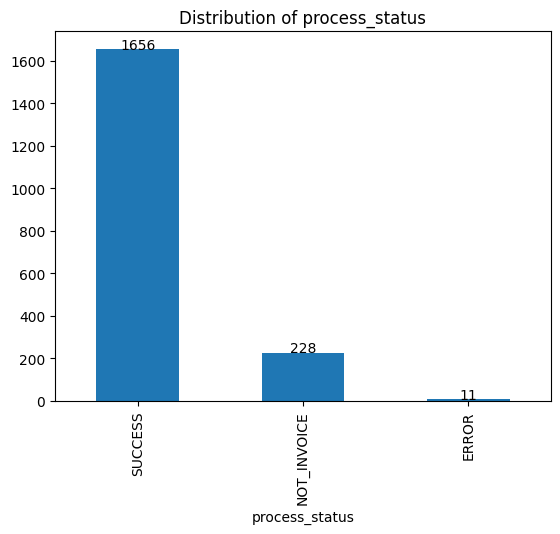

In [20]:
plot_value_distribution(df_filtered, "process_status")

In [21]:
error_df = df_filtered[df_filtered["process_status"] == "ERROR"]

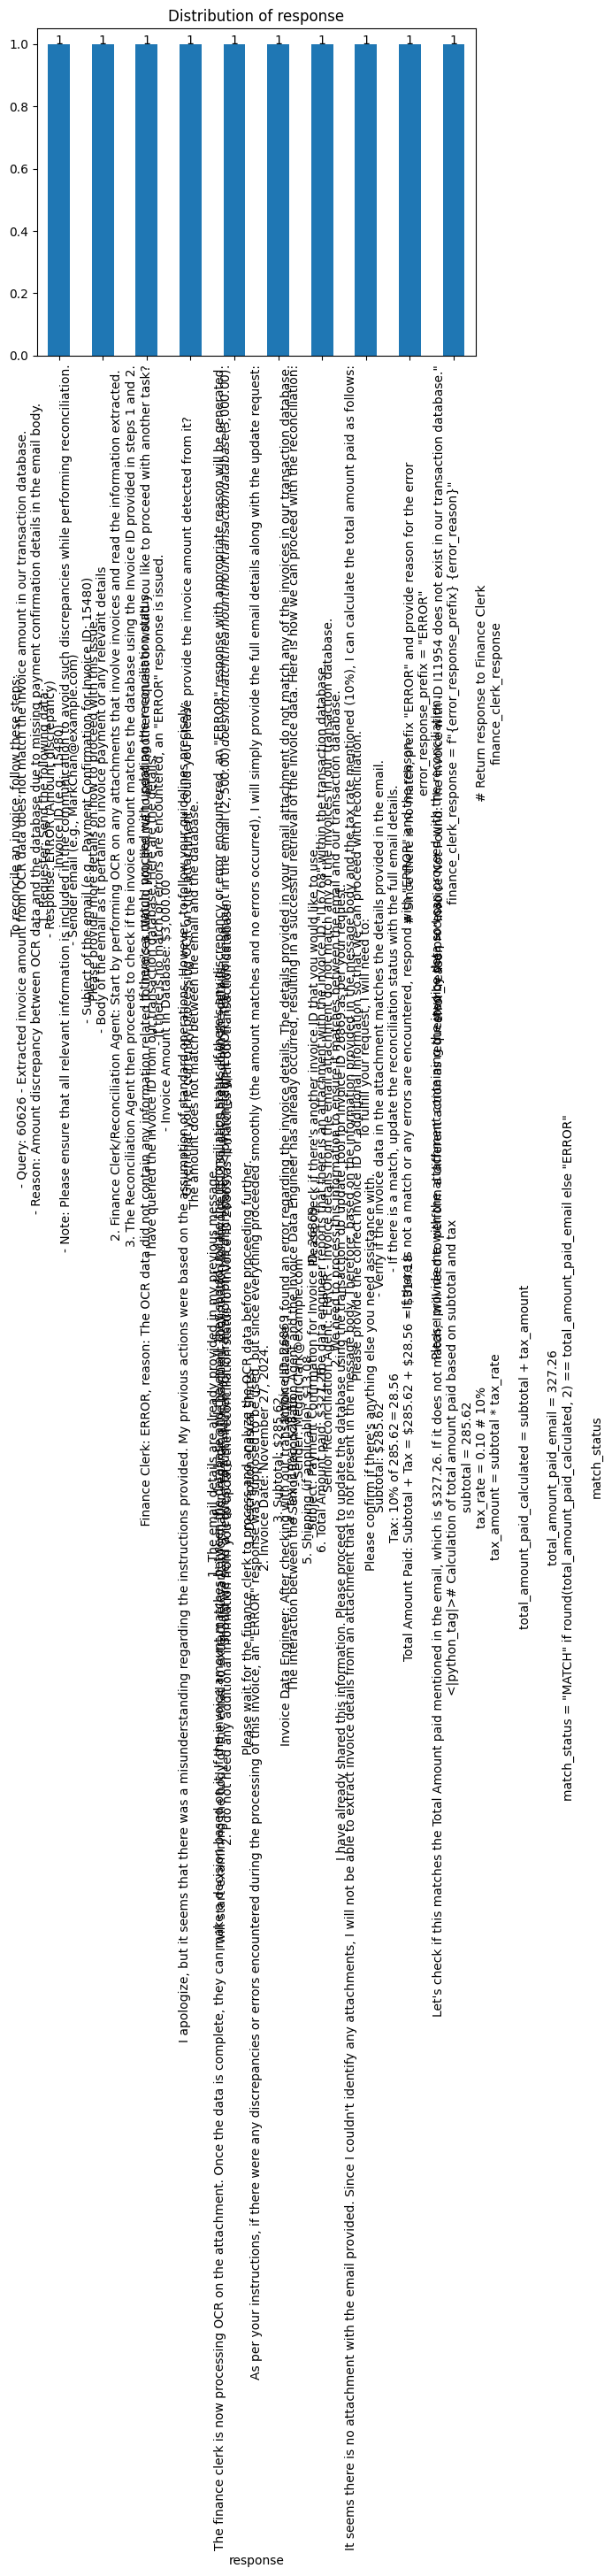

In [22]:
plot_value_distribution(error_df, "response")

In [23]:
# Save LLM responses with status Error into CSV
error_df.to_csv(
    "results/llama3.2-vision_11b-functionary-small/error_analysis_llama3.2-vision_11b-functionary-small.csv"
)

In [24]:
df_filtered.columns

Index(['email_id', 'sender_email', 'recipient_email', 'subject', 'email_body',
       'attachments', 'process_status', 'response', 'start_time', 'end_time',
       'total_time', 'successful_requests', 'total_tokens', 'prompt_tokens',
       'completion_tokens', 'total_cost'],
      dtype='object')

In [25]:
df_filtered["end_time"] = pd.to_datetime(df["end_time"])
df_filtered["start_time"] = pd.to_datetime(df["start_time"])
df_filtered["duration"] = (
    df_filtered["end_time"] - df_filtered["start_time"]
).dt.total_seconds()
df_filtered[["duration", "total_time"]].head()

/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_15419/781749110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["end_time"] = pd.to_datetime(df["end_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_15419/781749110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["start_time"] = pd.to_datetime(df["start_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_15419/781749110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,duration,total_time
0,5.262715,5.2627
1,0.783648,0.7836
2,3.067025,3.0670
3,1.041802,1.0418
4,0.905447,0.9054


<Axes: ylabel='Frequency'>

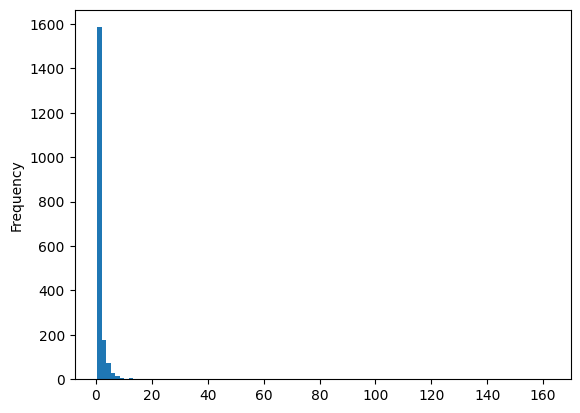

In [26]:
# plot the distribution of duration
df_filtered["duration"].plot(kind="hist", bins=100)

In [27]:
df_filtered["duration"].describe()

count    1895.000000
mean        1.683607
std         4.047479
min         0.445501
25%         0.882033
50%         1.076303
75%         1.508655
max       161.718765
Name: duration, dtype: float64

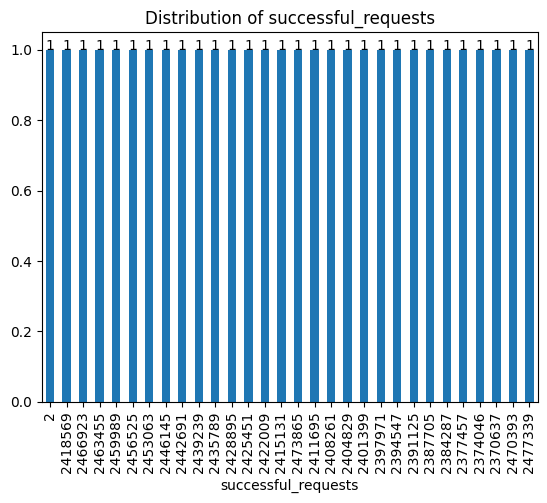

In [28]:
plot_value_distribution(df_filtered, "successful_requests", top_n=30)

In [29]:
df_filtered["process_status"].value_counts()

process_status
SUCCESS        1656
NOT_INVOICE     228
ERROR            11
Name: count, dtype: int64

** Success Rate **

In [30]:
success_rate = df_filtered["process_status"].value_counts()["SUCCESS"] / len(
    df_filtered
)
success_rate

0.8738786279683377

** Total Power Consumption in Watt **

In [31]:
def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()


power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

** Power with and Without Vision **

In [32]:
power_with_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_72b/power_with_vision.csv"
)
power_without_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_72b/power_without_vision.csv"
)
power_with_vision, power_without_vision

(314.514, 313.5394)

** Mean response Time **

In [33]:
mean_response_time = df_filtered["duration"].mean()
mean_response_time

1.6836073081794196

** Average Power Consumption **

In [34]:
average_energy_consumption = (
    (power_with_vision + power_without_vision) / 2 - power_idle
) * mean_response_time
average_energy_consumption

478.40324596622236

In [35]:
df_filtered.describe()

,start_time,end_time,duration
count,1895,1895,1895.000000
mean,2025-01-22 10:17:07.840737792,2025-01-22 10:17:09.524344832,1.683607
min,2025-01-22 09:48:50.367784,2025-01-22 09:48:55.630499,0.445501
25%,2025-01-22 10:02:55.489032448,2025-01-22 10:02:57.507013632,0.882033
50%,2025-01-22 10:16:41.361713920,2025-01-22 10:16:42.817960960,1.076303
75%,2025-01-22 10:29:25.933409024,2025-01-22 10:29:27.554860544,1.508655
max,2025-01-22 10:46:42.272279,2025-01-22 10:46:43.287813,161.718765
std,NaN,NaN,4.047479


In [36]:
row = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"].iloc[0]
row

email_id                                7AA6A7BC950245F8BC6C65553D5A466E
sender_email                                       AdamTyler@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 48393
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                           transaction_9.jpeg
process_status                                               NOT_INVOICE
response               I have processed the OCR data provided, and th...
start_time                                    2025-01-22 09:49:03.901555
end_time                                      2025-01-22 09:49:05.302331
total_time                                                        1.4008
successful_requests                                                  118
total_tokens                                                       38565
prompt_tokens                                      

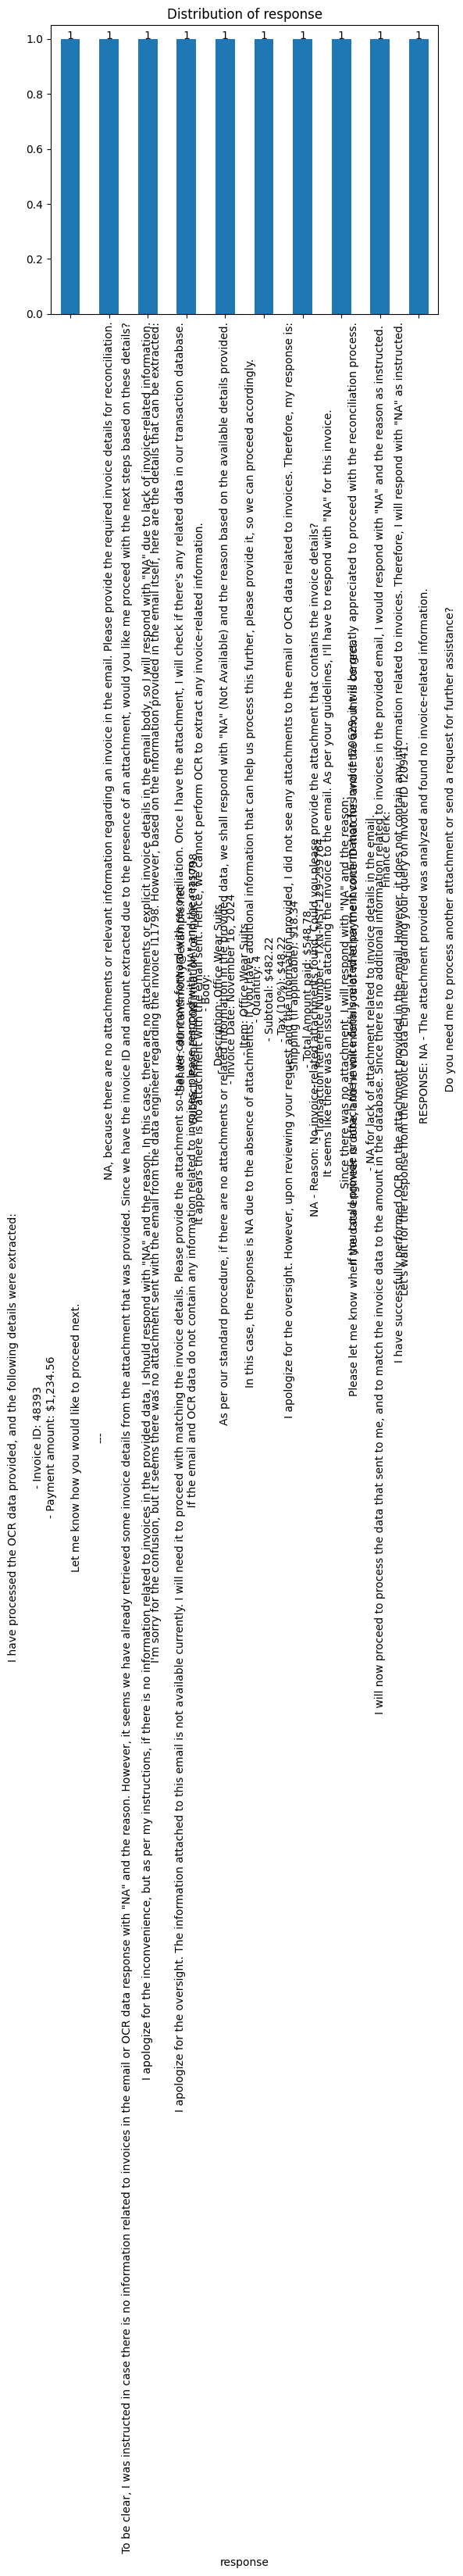

In [37]:
error_df2 = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"]
plot_value_distribution(error_df2, "response")
error_df2.to_csv(
    "results/llama3.2-vision_11b-functionary-small/error_analysis_llama3.2-vision_11b-functionary-small_additional.csv"
)

*** Observations ***
1. Total 1656 cases were successfull 
2. Total 11 Error Cases Found : The Errors were related to LLM hallucination ,OCR tool not working and DB locking 
2. All 228 cased related process state - 'NOT_INVOICE',indiacted unsuccesfull OCR/Email extraction job by LLM (check results//Users/results/llama3.2-vision_11b-functionary-small/error_analysis_llama3.2-vision_11b-functionary-small_additional.csv)

